In [114]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa as lib
import torch

import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchaudio
from scipy.io import wavfile
from torchaudio.compliance import kaldi
from tqdm.auto import tqdm
figure(figsize=(12, 8), dpi=80)

import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchaudio
from scipy.io import wavfile
from torchaudio.compliance import kaldi
from tqdm.auto import tqdm

<Figure size 960x640 with 0 Axes>

In [115]:
MUSICNET_DIR = "D:\\AI_MIDI\\midisynth_dataset-v1\\wav"
wav_paths = sorted(glob(f"{MUSICNET_DIR}/*.wav", recursive=True))

In [116]:
#สร้าง classmap ระหว่างโน๊ตและ index เพื่อให้ง่ายต่อโมเดล
df = pd.read_csv("D:\\AI_MIDI\\midisynth_dataset-v1\\labels.csv")
classm = df["note"].unique().tolist()
classmap=[]
for i in range(0,10):
    for c in 'CDEFGAB':
        if (c+str(i) in classm) :
            classmap.append(c+str(i))
        if (c+'#'+str(i) in classm) :
            classmap.append(c+'#'+str(i))

In [117]:
wav_path = wav_paths[0]
sr = 16000.0
wav, _ = torchaudio.load(wav_path)
fbank = kaldi.fbank(wav, sample_frequency=sr, num_mel_bins=120, frame_length=30)
if (wav_path[38]!='_') :
    label = str(classmap.index(wav_path[36:39]))
else :
    label = str(classmap.index(wav_path[36:38]))
if len(label)==1:
    label = '0'+label

len(wav[0])

34624

In [109]:
MUSICNET_DIR = "D:\\AI_MIDI\\midisynth_dataset-v1\\wav"
class DATA_Prepare():
    def __init__(self, transformation, device):
        self.MUSICNET_DIR = "D:\\AI_MIDI\\midisynth_dataset-v1\\wav"
        self.target_sample_rate = 16000.0
        self.device = device
        self.transformation = transformation.to(self.device)

    def get_data(self) :
        wav_paths = sorted(glob(f"{self.MUSICNET_DIR}/*.wav", recursive=True))      
        data=[]
        for wav_path in wav_paths:
            print(wav_path)
            signal, sr = torchaudio.load(wav_path)
            signal = self._resample_if_necessary(signal, sr)
            signal = self._mix_down_if_necessary(signal)
            signal = self.transformation(signal)
            if (wav_path[38]!='_') :
                label = classmap.index(wav_path[36:39])
            else :
                label = classmap.index(wav_path[36:38])
                    
            data.append({"data": signal,"label": label})

        return data

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

In [108]:
 mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=34624,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)
device = "cuda" if torch.cuda.is_available() else "cpu"

feat = DATA_Prepare(mel_spectrogram, device)
data = feat.get_data()

D#4


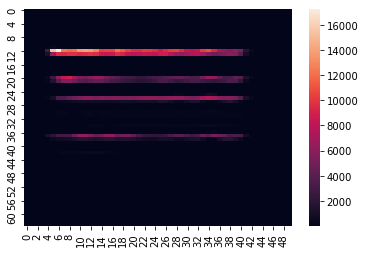

In [113]:
import seaborn as sns
id = 6
print(classmap[data[id]["label"]])
sns.heatmap(data[id]["data"][0])

In [ ]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchaudio
from scipy.io import wavfile
from torchaudio.compliance import kaldi
from tqdm.auto import tqdm


def sample_to_frames(
    t_sample,
    frame_size=10, # ms / frame
    sampling_rate=44100
):
    t_sec = t_sample / sampling_rate  # (sample) / (sample / sec)
    t_frame = t_sec / (frame_size / 1000) # (sec) / (sec / 1000*frame)
    return int(t_frame)


def get_data(set_name="train", n_notes=88):
    # check if set_name is valid or not
    if set_name.lower().strip() not in ["train", "test"]:
        raise NameError(f"Unrecognized set name: {set_name}")
    
    wav_paths = sorted(glob(f"{MUSICNET_DIR}/{set_name}_data/**/*.wav", recursive=True))
    csv_paths = [wav.replace("_data", "_labels").replace(".wav", ".csv") for wav in wav_paths]
    #print(csv_paths)
    assert all(os.path.exists(csv) for csv in csv_paths)
    
    data = []
    for wav_path, csv_path in tqdm(zip(wav_paths, csv_paths), total=len(wav_paths)):
        wav, sr = torchaudio.load(wav_path)
        # config feature here
        fbank = kaldi.fbank(wav, sample_frequency=sr, num_mel_bins=120, frame_length=30)
        
        label = pd.read_csv(csv_path)
        y = np.zeros([fbank.shape[0], n_notes])
        for  i, row in label.iterrows():
            y[sample_to_frames(row["start_time"]):sample_to_frames(row["end_time"]), row["note"] - 20] = 1
            
        data.append({"wav_path": wav_path, "label": y, "feature": fbank})
    
    return data

In [2]:
class UrbanSoundDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        fold = f"fold{self.annotations.iloc[index, 5]}"
        path = os.path.join(self.audio_dir, fold, self.annotations.iloc[
            index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]

## DATALOADER

In [7]:
if __name__ == "__main__":
    ANNOTATIONS_FILE = "D:\\AI_pitch_Data\\UrbanSound8K\\metadata\\UrbanSound8K.csv"
    AUDIO_DIR = "D:\\AI_pitch_Data\\UrbanSound8K\\audio"
    SAMPLE_RATE = 22050
    NUM_SAMPLES = 22050

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device {device}")

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

    usd = UrbanSoundDataset(ANNOTATIONS_FILE,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device)
    print(f"There are {len(usd)} samples in the dataset.")
    signal, label = usd[0]

Using device cpu
There are 8732 samples in the dataset.


In [22]:
batch_size = 128
train_dataloader = DataLoader(usd, batch_size=batch_size)

## Model

In [19]:
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader

class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 5 * 4, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return 

In [20]:
batch_size = 128
epochs = 10
lr = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model=CNNNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
def train_one_epoch(model, data_loader, loss_fn, optimiser, device):
  for inputs, targets in data_loader :
    inputs, targets = inputs.to(device), targets.to(device)
  
  #calculate loss
  pred = model(inputs)
  loss = loss_fn(pred, targets)
  #acc = Acc_fn(pred, targets)

  #backpropagate + update weight
  optimiser.zero_grad() #ลบ gradiun จาก batch ก่อนๆ
  loss.backward()
  optimiser.step()

  print(f"Loss : {loss.item()}") #\t Acc:{acc}")

def train(model, data_loader, loss_fn, optimiser, device, epoch):
  for i in range(epoch):
    print(f"Epoch : {i+1}")
    train_one_epoch(model, data_loader, loss_fn, optimiser, device)
    print("---------------------------")
  print("Finished training")

In [ ]:
train(model, train_dataloader, loss_fn, optimiser, device, epochs)
torch.save(model.state_dict(), "model.pth")
print("Trained feed forward net saved at feedforwardnet.pth")